# 1. Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.market_data import load_zc_curve
from src.zc_curve import yields_to_prices, prices_to_yields
from src.ir_api import calibrate_short_rate_model, analyze_term_structure, price_benchmark_products
from src.plotting import plot_zc_yields_vs_model, plot_zc_prices_error

# 2. Load / Define “market” ZC curve
This csv file can be simulated, real (from bootstrapping generated from  OAT, ESTR, swaps)

In [3]:
# Load from CSV 
path_csv = "data/eur_zc_curve.csv"
zc_df = load_zc_curve(path_csv)

zc_df

,maturity_years,zc_yield
0,0.5,0.015
1,1.0,0.017
2,2.0,0.019
3,5.0,0.021
4,10.0,0.023
5,20.0,0.024


# 3. Model choice & calibration

In [4]:
# Choose model: 'vasicek' or 'cir'
model_type = "vasicek"

calibrated_model, calib_info, curve_used = calibrate_short_rate_model(
    zc_curve_df=zc_df,
    model_type=model_type,
    use_cleaned_curve=True,
)

print("=== Calibrated model parameters ===")
print(calibrated_model)
print("\n=== Calibration diagnostics ===")
for k, v in calib_info.items():
    print(f"{k}: {v}")

=== Calibrated model parameters ===
CalibratedModel(model_type='vasicek', params=VasicekParams(kappa=0.5000292392753602, theta=0.025227899570776348, sigma=0.009918106158728705, r0=0.014568860527622433))

=== Calibration diagnostics ===
success: True
message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
n_iter: 6
final_loss: 2.3366757869184734e-06
params_hat: {'kappa': 0.5000292392753602, 'theta': 0.025227899570776348, 'sigma': 0.009918106158728705, 'r0': 0.014568860527622433}
clean_info: {'n_original': 6, 'n_clean': 6, 'n_removed': 0, 'outlier_yield_bounds': (0.002500000000000009, 0.03749999999999999)}


# 4. Term structure analysis (model curve vs market)

RMSE on prices: 0.000624
RMSE on yields: 0.000409


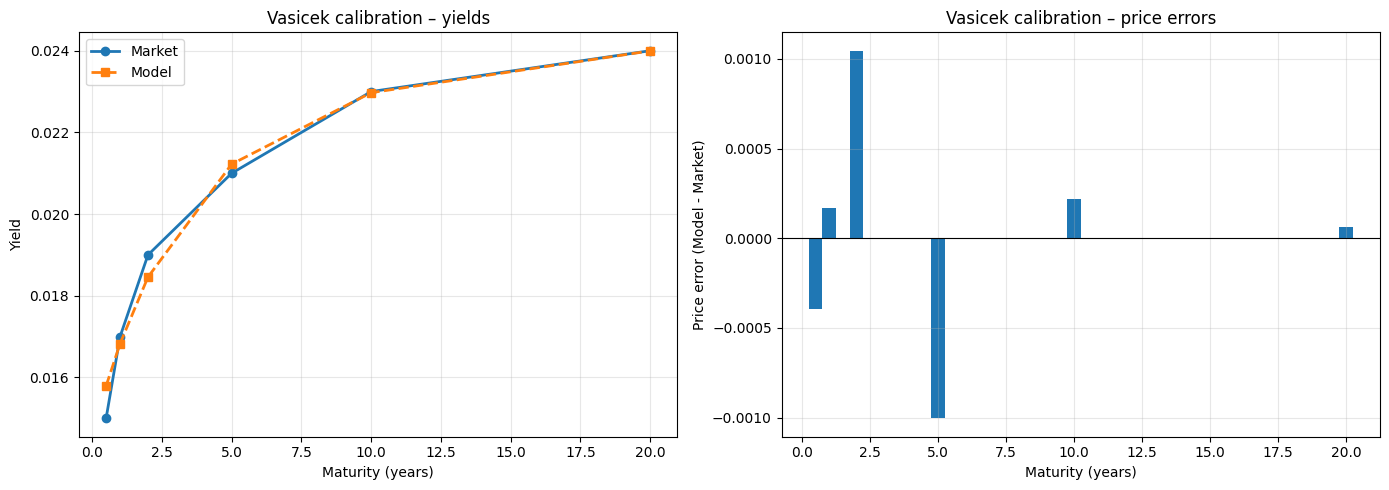

In [5]:
analysis = analyze_term_structure(curve_used, calibrated_model)

print(f"RMSE on prices: {analysis['rmse_prices']:.6f}")
print(f"RMSE on yields: {analysis['rmse_yields']:.6f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: yields comparison
axes[0].plot(analysis["maturities"], analysis["market_yields"], 'o-', label='Market', linewidth=2)
axes[0].plot(analysis["maturities"], analysis["model_yields"], 's--', label='Model', linewidth=2)
axes[0].set_xlabel("Maturity (years)")
axes[0].set_ylabel("Yield")
axes[0].set_title(f"{model_type.capitalize()} calibration – yields")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: price errors
price_errors = analysis["model_prices"] - analysis["market_prices"]
axes[1].bar(analysis["maturities"], price_errors, width=0.5)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel("Maturity (years)")
axes[1].set_ylabel("Price error (Model - Market)")
axes[1].set_title(f"{model_type.capitalize()} calibration – price errors")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Simple products Pricing (ZC, FRA, Swaps)

In [6]:
bench = price_benchmark_products(calibrated_model, curve_used, notional=1_000_000)

print("=== Benchmark products (model-implied) ===")
for k, v in bench.items():
    print(f"{k}: {v:.6f}")

=== Benchmark products (model-implied) ===
P_5Y: 0.899321
P_10Y: 0.794753
FRA_1Y_2Y_ATM_price: 0.000000
par_swap_rate_2Y_10Y: 0.023132
swap_value_payer_2Y_10Y: 0.000000


# Bonus  : Vasicek Trajectories Simulation & Distribution
#### *(Works if Vasicek Model chosen in 2.)* 

(Also feasable for CIR)    

In [7]:
from src.ir_models import VasicekParams

def simulate_vasicek_paths(params: VasicekParams, T: float, n_steps: int, n_paths: int, seed: int = 42):
    """
    Simulate Vasicek short-rate paths using Euler discretization.

    dr_t = kappa (theta - r_t) dt + sigma dW_t

    Parameters
    ----------
    params : VasicekParams
        Calibrated Vasicek parameters.
    T : float
        Final time horizon (years).
    n_steps : int
        Number of time steps.
    n_paths : int
        Number of simulated paths.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    t_grid : ndarray of shape (n_steps + 1,)
        Time grid from 0 to T.
    paths : ndarray of shape (n_paths, n_steps + 1)
        Simulated short-rate paths.
    """
    np.random.seed(seed)
    kappa, theta, sigma, r0 = params.kappa, params.theta, params.sigma, params.r0

    dt = T / n_steps
    t_grid = np.linspace(0.0, T, n_steps + 1)

    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = r0

    for i in range(n_steps):
        r_t = paths[:, i]
        dW = np.sqrt(dt) * np.random.randn(n_paths)
        dr = kappa * (theta - r_t) * dt + sigma * dW
        paths[:, i + 1] = r_t + dr

    return t_grid, paths

# Exemple : simuler 10 ans, 250 pas, 2000 trajectoires
t_grid, r_paths = simulate_vasicek_paths(
    calibrated_model.params,
    T=10.0,
    n_steps=250,
    n_paths=2000,
)

t_grid.shape, r_paths.shape


((251,), (2000, 251))

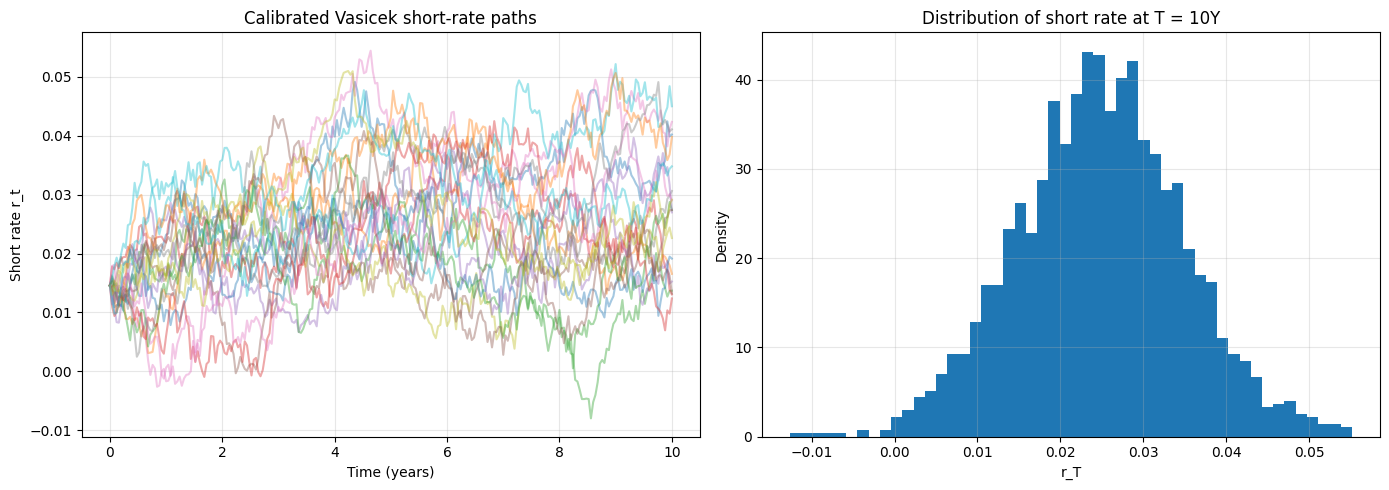

In [11]:
# Plot sample paths and distribution side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Sample paths
for i in range(20):
    axes[0].plot(t_grid, r_paths[i, :], alpha=0.4)
axes[0].set_xlabel("Time (years)")
axes[0].set_ylabel("Short rate r_t")
axes[0].set_title("Calibrated Vasicek short-rate paths")
axes[0].grid(True, alpha=0.3)

# Right plot: Distribution at T=10Y
r_T = r_paths[:, -1]
axes[1].hist(r_T, bins=50, density=True)
axes[1].set_xlabel("r_T")
axes[1].set_ylabel("Density")
axes[1].set_title("Distribution of short rate at T = 10Y")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
print("Parameters used for simulation:", calibrated_model.params)

Parameters used for simulation: VasicekParams(kappa=0.5000292392753602, theta=0.025227899570776348, sigma=0.009918106158728705, r0=0.014568860527622433)
